### **Load Data from Drive**

In [ ]:
# Provide access to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Let's first load the dataset and examine the contents to understand its structure, so we can proceed with data cleaning and preprocessing before developing the ML model.
import pandas as pd

# Load the dataset
file_path = '/content/gdrive/My Drive/Kidney Disease Prediction/kidney_disease.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
# Check for missing values and the data types of columns to understand the preprocessing steps required
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

### **Data Preprocessing & EDA**

In [5]:
# Handle non-numeric values in 'pcv', 'wc', 'rc' columns by converting them to numeric and coercing errors to NaN
data['pcv'] = pd.to_numeric(data['pcv'], errors='coerce')
data['wc'] = pd.to_numeric(data['wc'], errors='coerce')
data['rc'] = pd.to_numeric(data['rc'], errors='coerce')

# Fill missing values for numeric columns with the median
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# For categorical columns, fill missing values with the mode
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Convert binary categorical variables (yes/no, present/notpresent, etc.) to numeric
binary_mapping = {'yes': 1, 'no': 0, 'present': 1, 'notpresent': 0}
for col in ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']:
    data[col] = data[col].map(binary_mapping)

# Encode the target variable: 'ckd' -> 1, 'notckd' -> 0
data['classification'] = data['classification'].map({'ckd': 1, 'notckd': 0})

# Drop the 'id' column as it is irrelevant for the analysis
data = data.drop('id', axis=1)

# Verify the dataset after preprocessing
data.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,NaN,0,0,121.0,...,44.0,7800.0,5.2,1,1.0,0.0,NaN,0,0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,NaN,0,0,121.0,...,38.0,6000.0,4.8,0,0.0,0.0,NaN,0,0,1.0
2,62.0,80.0,1.010,2.0,3.0,NaN,NaN,0,0,423.0,...,31.0,7500.0,4.8,0,1.0,0.0,NaN,0,1,1.0
3,48.0,70.0,1.005,4.0,0.0,NaN,NaN,1,0,117.0,...,32.0,6700.0,3.9,1,0.0,0.0,NaN,1,1,1.0
4,51.0,80.0,1.010,2.0,0.0,NaN,NaN,0,0,106.0,...,35.0,7300.0,4.6,0,0.0,0.0,NaN,0,0,1.0


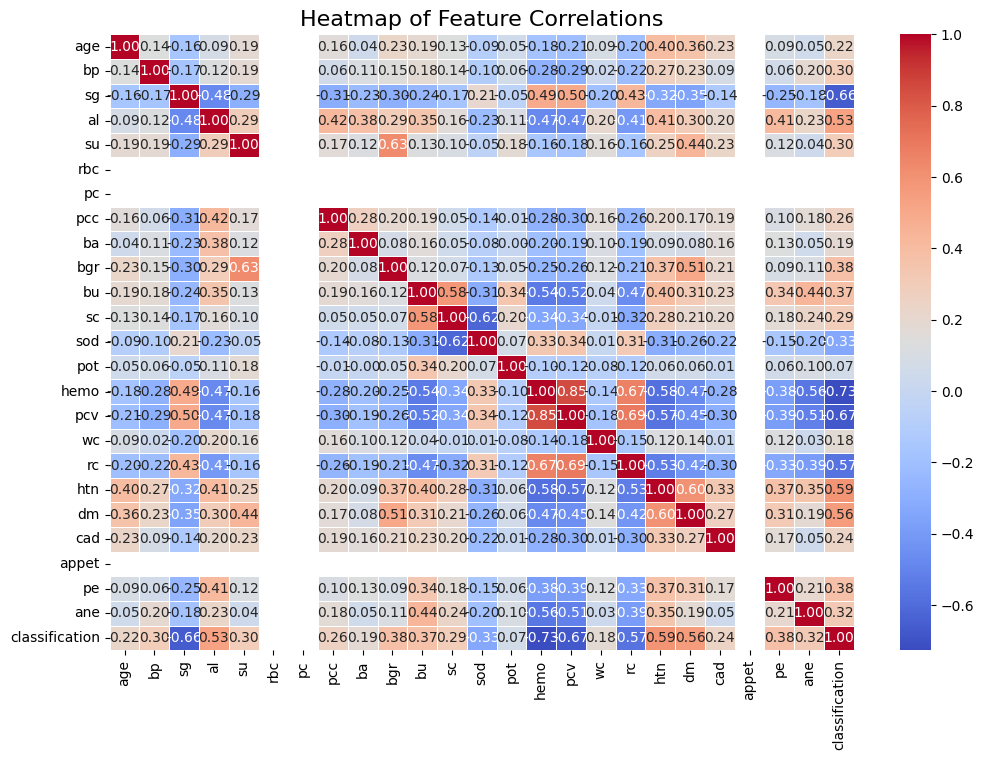

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# After preprocessing, create a correlation matrix for numeric features
correlation_matrix = data.corr()

# Set up the figure size
plt.figure(figsize=(12, 8))

# Generate a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title for clarity
plt.title('Heatmap of Feature Correlations', size=16)

# Show the plot
plt.show()

In [7]:
# Select the target variable 'y' (the last column in the dataset)
# This column contains the labels indicating whether a patient has CKD or not.
y=data.iloc[:,[-1]] # Use iloc to select the last column of the dataset (classification)

In [8]:
# Select the feature variables 'X' (all columns except the last one)
# These columns contain the input features like age, blood pressure, etc.
X=data.iloc[:,:-1] # Use iloc to select all columns except the last one

### **Split the Data**

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# 'X' are the input features (e.g., age, blood pressure, etc.)
# 'y' is the target variable (whether CKD is present or not)

# train_test_split function divides the data into a training set and a test set
# test_size=0.2 means 20% of the data will be used for testing, and 80% for training
# random_state=42 ensures that the split is reproducible (i.e., you get the same split every time you run the code)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# X_train: 80% of the input features used for training the model
# X_test: 20% of the input features used for testing the model
# y_train: 80% of the target labels used for training the model
# y_test: 20% of the target labels used for testing the model

# Print the split datsets
print("X_train    : ",X_train.shape)
print("X_test : ",X_test.shape)
print("y_train    : ",y_train.shape)
print("y_test : ",y_test.shape)

X_train    :  (320, 24)
X_test :  (80, 24)
y_train    :  (320, 1)
y_test :  (80, 1)


In [11]:
# View the training data
X_train

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
3,48.0,70.0,1.005,4.0,0.0,NaN,NaN,1,0,117.0,...,11.2,32.0,6700.0,3.9,1,0.0,0.0,NaN,1,1
18,60.0,100.0,1.025,0.0,3.0,NaN,NaN,0,0,263.0,...,12.7,37.0,11400.0,4.3,1,1.0,1.0,NaN,0,0
202,78.0,60.0,1.020,0.0,0.0,NaN,NaN,0,0,114.0,...,8.0,24.0,8000.0,4.8,0,1.0,0.0,NaN,0,1
250,40.0,80.0,1.025,0.0,0.0,NaN,NaN,0,0,140.0,...,15.0,48.0,10400.0,4.5,0,0.0,0.0,NaN,0,0
274,19.0,80.0,1.020,0.0,0.0,NaN,NaN,0,0,107.0,...,14.4,44.0,8000.0,4.8,0,0.0,0.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,46.0,60.0,1.010,1.0,0.0,NaN,NaN,0,0,163.0,...,9.8,28.0,14600.0,3.2,1,1.0,0.0,NaN,0,0
106,50.0,90.0,1.020,0.0,0.0,NaN,NaN,0,0,89.0,...,6.0,17.0,6500.0,4.8,1,1.0,0.0,NaN,1,1
270,23.0,80.0,1.025,0.0,0.0,NaN,NaN,0,0,111.0,...,14.3,41.0,7200.0,5.0,0,0.0,0.0,NaN,0,0
348,38.0,80.0,1.020,0.0,0.0,NaN,NaN,0,0,99.0,...,13.6,44.0,7300.0,6.4,0,0.0,0.0,NaN,0,0


In [12]:
# Summary of statistical information for the training data (X_train)
X_train.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
count,320.000000,320.000000,320.000000,320.000000,320.000000,0.0,0.0,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,315.000000,318.000000,0.0,320.000000,320.000000
mean,50.965625,76.093750,1.017750,0.881250,0.384375,NaN,NaN,0.096875,0.056250,147.103125,...,12.605781,39.378125,8308.750000,4.749688,0.350000,0.342857,0.084906,NaN,0.181250,0.143750
std,17.392088,13.852921,0.005494,1.295625,1.019745,NaN,NaN,0.296251,0.230765,74.227212,...,2.662704,7.886190,2570.922221,0.816330,0.477717,0.475419,0.279181,NaN,0.385829,0.351386
min,2.000000,50.000000,1.005000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,70.000000,...,3.100000,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
25%,41.000000,70.000000,1.015000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,102.000000,...,10.900000,34.000000,6900.000000,4.500000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
50%,54.500000,80.000000,1.020000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,121.000000,...,12.650000,40.000000,8000.000000,4.800000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
75%,64.000000,80.000000,1.020000,2.000000,0.000000,NaN,NaN,0.000000,0.000000,158.250000,...,14.700000,44.000000,9400.000000,5.100000,1.000000,1.000000,0.000000,NaN,0.000000,0.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,NaN,NaN,1.000000,1.000000,490.000000,...,17.800000,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [13]:
# Check for NaN or NULL values in y
y.isnull().sum()

,0
classification,2


In [14]:
# Remove rows where the target variable has NaN values
data_cleaned = data.dropna(subset=['classification'])

# Split the dataset again into features (X) and target (y)
X = data_cleaned.drop('classification', axis=1)
y = data_cleaned['classification']

In [15]:
# Check if anu Nan or Null values exist
y.isnull().sum()

0

In [16]:
# Split again after removing null values from y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Train a Random Forest Model**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

# Train a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Specificity
specificity = tn / (tn + fp)

# Display results in percentage format
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")

# Confusion matrix interpretation
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%
Specificity: 100.00%

Confusion Matrix:
[[28  0]
 [ 0 52]]
True Negatives: 28
False Positives: 0
False Negatives: 0
True Positives: 52


In [21]:
# Print Classification Report, if required

# Classification Report: Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        28
         1.0       1.00      1.00      1.00        52

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [19]:
# Cross validate the accuracy to confirm the results
from sklearn.model_selection import cross_val_score
cross_val_accuracy = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cross_val_accuracy.mean()}")

Cross-Validation Accuracy: 0.9924683544303796


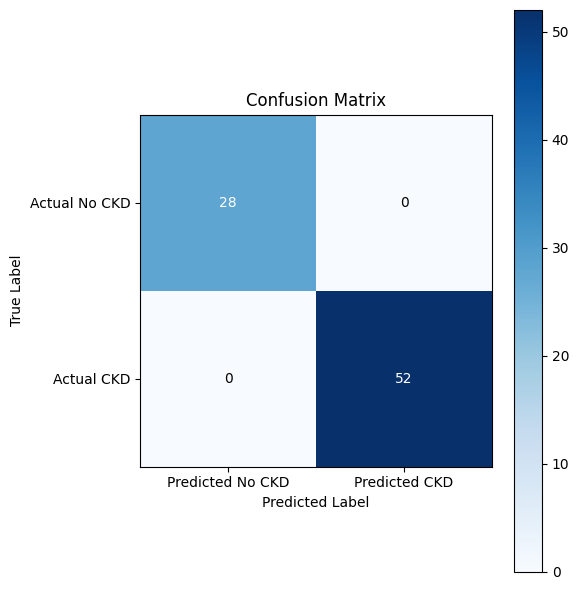

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix values
tn, fp, fn, tp = conf_matrix.ravel()

# Create a matrix for visualization
confusion_matrix_values = np.array([[tn, fp],
                                    [fn, tp]])

# Create labels for the matrix
labels = np.array([['True Negatives', 'False Positives'],
                   ['False Negatives', 'True Positives']])

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(confusion_matrix_values, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding text annotations
thresh = confusion_matrix_values.max() / 2.
for i, j in np.ndindex(confusion_matrix_values.shape):
    plt.text(j, i, f'{confusion_matrix_values[i, j]}',
             ha='center', va='center',
             color='white' if confusion_matrix_values[i, j] > thresh else 'black')

# Set the ticks and labels
plt.xticks(np.arange(2), ['Predicted No CKD', 'Predicted CKD'])
plt.yticks(np.arange(2), ['Actual No CKD', 'Actual CKD'])

# Add axis labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.tight_layout()
plt.show()
